In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
inspector.get_columns("measurement")

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [9]:
inspector.get_columns("station")

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [10]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
date_descending = session.query(measurements.date).order_by(measurements.date.desc())
date_descending.first()

('2017-08-23',)

In [13]:
# Starting from the most recent data point in the database. 
# Calculate the date one year from the newest date in data set.
year_from_last = dt.date.fromisoformat((date_descending[0][0]))-dt.timedelta(days=365)
year_from_last

datetime.date(2016, 8, 23)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Perform a query to retrieve the data and precipitation scores
last_12 = session.query(measurements.date, func.sum(measurements.prcp))\
    .group_by(measurements.date)\
    .filter(measurements.date > "2016-08-23")
date_last_12 = [x[0] for x in last_12]
precip_last_12 = [x[1] for x in last_12]

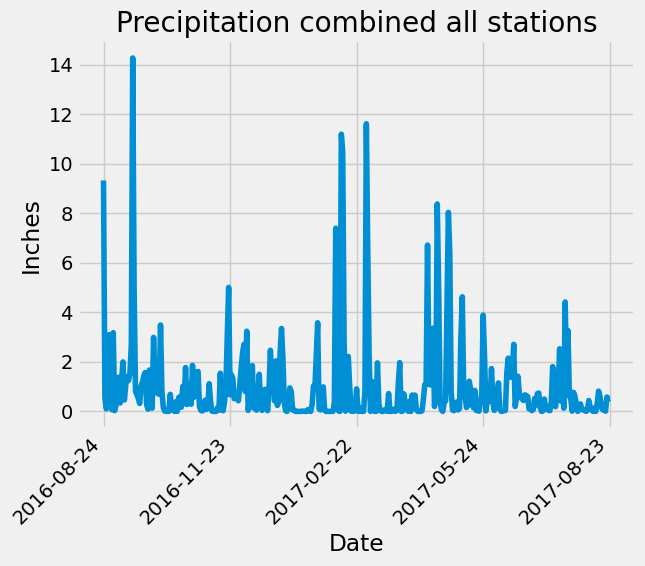

In [15]:
plt.title("Precipitation combined all stations")
plt.ylabel("Inches")
plt.xlabel("Date")
xticks = [0, 91, 182, 273, 364]
plt.xticks(ticks=xticks, rotation=45, ha="right")
plt.plot(date_last_12, precip_last_12)
plt.show()

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
last_12_df = pd.DataFrame(last_12,columns=["Date","Precipitation"]).set_index("Date")
# Sort the dataframe by date
last_12_df = last_12_df.sort_index()
last_12_df.head()

,Precipitation
Date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


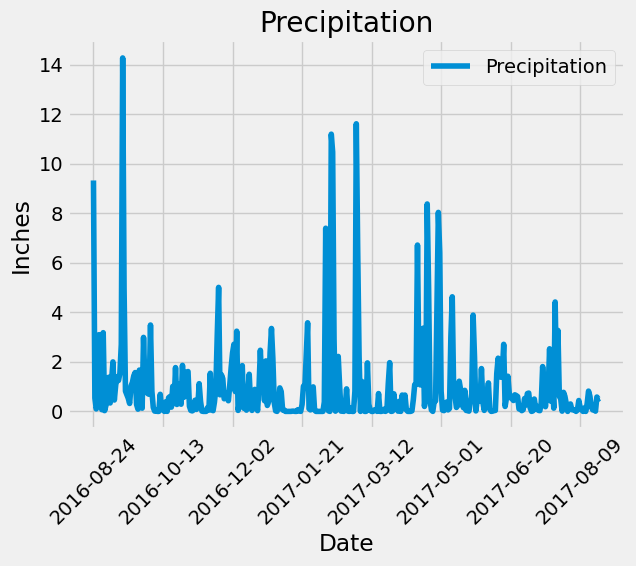

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
last_12_df.plot(xlabel="Date",ylabel="Inches",title="Precipitation",rot=45)
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_df[["Precipitation"]].describe()

,Precipitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(stations.id))
total_stations.first()

(9,)

In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurements.station, func.count(measurements.date)).group_by(measurements.station).order_by(func.count(measurements.date).desc())

for x in active_stations:
    print(x)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
USC00519281_min_avg_max = session.query(measurements.station, func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs))\
    .filter(measurements.station == "USC00519281")
USC00519281_min_avg_max.first()

('USC00519281', 54.0, 71.66378066378067, 85.0)

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_tobs_last_12 = session.query(measurements.date, measurements.tobs)\
                            .filter(measurements.station == "USC00519281")\
                            .filter(measurements.date > "2016-08-23")

In [23]:
USC00519281_tobs_last_12_df = pd.DataFrame(USC00519281_tobs_last_12, columns=["Date", "TOBS"])
USC00519281_tobs_last_12_df

,Date,TOBS
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
...,...,...
346,2017-08-14,77.0
347,2017-08-15,77.0
348,2017-08-16,76.0
349,2017-08-17,76.0


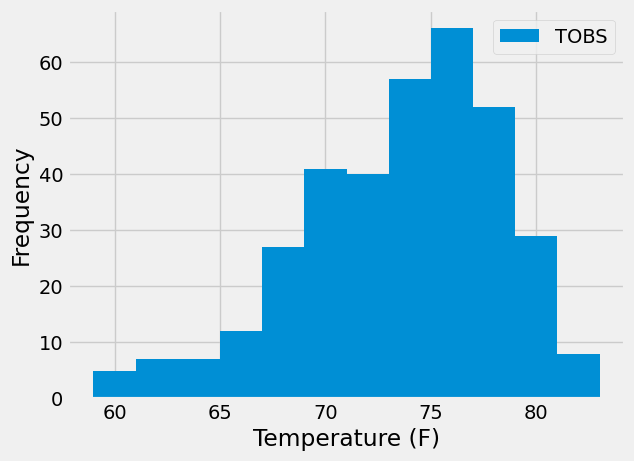

In [24]:
USC00519281_tobs_last_12_df.plot.hist(bins=12)
plt.xlabel("Temperature (F)")
plt.show()

# Close session

In [25]:
# Close Session
session.close()